# Analyze results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
import random

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, AUC
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/MyDrive/medical_image_processing/

Mounted at /content/gdrive
/content/gdrive/MyDrive/medical_image_processing


In [ ]:
from copy import deepcopy
from glob import glob
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, jaccard_score, recall_score, precision_score
from tqdm import tqdm

# prediction_path = "predictions"

""" Make the prediction and calculate the metrics values """
def compute_metrics(data_path:str,
                    results_path:str,
                    threshold:float,
                    model=None,
                    predictions_path:str=None,
                    prediction_np_path=None):
    """ Load the dataset """
    test_x, test_y = get_filenames_sorted(f"{data_path}/image", f"{data_path}/mask")
    SCORE = []
    print("Threshold", threshold)
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x) ):
        if model is None and predictions_path is None:
            raise Exception("Invalid input parameters. Both model and prediction_path can not be None")
        """ Extracting name """
        name = x.split("/")[-1].split(".")[0]

        """ Read the image and mask """
        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)
        y = y.astype(np.int)
        print(name)

    #     """ Prediction """
        if model != None:
            y_pred = model.predict(np.expand_dims(x, axis=0))[0]
        else:
            print("Reading predicted image from ",f"{predictions_path}/{name}.png")
            orig_y_pred, y_pred = read_mask(f"{predictions_path}/{name}.png")
            print(y_pred.shape, np.max(orig_y_pred), np.min(orig_y_pred))
        print(y_pred.shape, np.max(y_pred), np.min(y_pred))
        if prediction_np_path is not None:
            np.save(f"{prediction_np_path}/{name}.npy", y_pred)


        y_prob = deepcopy(y_pred).flatten()
        y_pred = y_pred > threshold
        y_pred = y_pred.astype(np.int32)
        y_pred = np.squeeze(y_pred)


        """ Saving the images """
        save_image_path = f"{results_path}/{name}.png"
        print(ori_x.shape, ori_y.shape,y_pred.shape)
        save_results(ori_x, ori_y, y_pred, save_image_path)
        
        if model is not None:
            cv2.imwrite(f"{prediction_path}/{name}.png", y_pred * 255)
        

        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculate the metrics """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
        if np.sum(y) == 0 or np.sum(y) == H * W:
            auc_value = 1
        else:
            auc_value = roc_auc_score(y, y_prob)
        dice_value = dice_coef(y.astype(np.float64), y_prob)

        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, auc_value, dice_value])

    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")
    print(f"AUC: {score[5]:0.5f}")
    print(f"Dice Coeff: {score[6]:0.5f}")

    """ Saving """
    df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "AUC", "Dice Coef"])
    df.to_csv(f"{results_path}/score_full.csv")
    return df, score

In [ ]:
from fundal_image.utils import create_dir
from fundal_image.utils import get_filenames_sorted
from patches import reconstruct_patches

In [ ]:
loss_str = "dice_loss"
with_augmentation = True
stride=512
test_percentage=0.3

In [ ]:
image_sizes = {"HRF": (2336, 3504), "drive": (584, 565), "chase_db": (960, 999)}
patch_size = {"HRF": (512, 512)}

dataset_name = "HRF"
num_pixels_to_add = [0, 0]
if (image_sizes["HRF"][0] % patch_size["HRF"][0]) > 0:
    num_pixels_to_add[0] = ((image_sizes["HRF"][0] // patch_size["HRF"][0]) + 1) * patch_size["HRF"][0]
    num_pixels_to_add[1] = ((image_sizes["HRF"][1] // patch_size["HRF"][1]) + 1) * patch_size["HRF"][1]


In [ ]:
num_pixels_to_add

[2560, 3584]

In [ ]:

seed = 42

aug_string = ""
if with_augmentation:
    aug_string = "_hvr"
root_path = f"/content/datasets/hrf_512_{stride}_{loss_str}{aug_string}/"
images_path = f"{root_path}/images/"
gt_path = f"{root_path}/groundtruth"
create_dir("/content/datasets/")
# create_dir(images_path)
# create_dir(gt_path)

In [ ]:
print(root_path)

/content/datasets/hrf_512_512_dice_loss_hvr/


In [ ]:
%cd /content/datasets/

/content/datasets


In [ ]:
!ls /content/gdrive/MyDrive/Blood_Vessel_Results/hrf_patches/

02_g_test.png
hrf_512_256_bce_hvr_xval_10_42.zip
hrf_512_512
hrf_512_512_bce
hrf_512_512_bce_2
hrf_512_512_bce_2.zip
hrf_512_512_bce_hvr
hrf_512_512_bce_hvr_0_3
hrf_512_512_bce_hvr_0_33_42.zip
hrf_512_512_bce_hvr_0_33_43
hrf_512_512_bce_hvr_0_33_43.zip
hrf_512_512_bce_hvr_0_3_44
hrf_512_512_bce_hvr_0_3_44.zip
hrf_512_512_bce_hvr_feb_3_1.zip
hrf_512_512_bce_hvr_xval_2_42.zip
hrf_512_512_bce_hvr_xval_5_42
hrf_512_512_bce_hvr_xval_5_42_10epochs
hrf_512_512_bce_hvr_xval_5_42.csv
hrf_512_512_bce_hvr.zip
hrf_512_512_bce.zip
hrf_512_512_dice
hrf_512_512_dice_bce
hrf_512_512_dice_bce_hvr
hrf_512_512_dice_bce_hvr_2.zip
hrf_512_512_dice_bce_hvr_jan_31_2.zip
hrf_512_512_dice_bce_hvr_jan_31.zip
hrf_512_512_dice_bce_hvr_xval_5_42.zip
hrf_512_512_dice_bce_hvr_xval_9_42_10epochs.zip
hrf_512_512_dice_bce_hvr.zip
hrf_512_512_DiceBCELoss
hrf_512_512_dice_loss_2
hrf_512_512_dice_loss_2.zip
hrf_512_512_dice_loss_hvr_0_3_feb_3.zip
hrf_512_512_dice_loss_hvr_xval_5_42.zip
hrf_512_512_dice.zip
hrf_512_512.zip

In [ ]:
!unzip /content/gdrive/MyDrive/Blood_Vessel_Results/hrf_patches/hrf_512_512_dice_loss_hvr_0_3_feb_3.zip

Streaming output truncated to the last 5000 lines.
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_01_g_0_8.png  
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_08_h_1_26.png  
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_07_dr_0_4.png  
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_15_g_3_26.png  
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_09_h_3_34.png  
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_10_dr_2_15.png  
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_04_h_1_31.png  
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_03_g_0_11.png  
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_04_h_0_20.png  
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_14_g_2_18.png  
  inflating: hrf_512_512_dice_loss_hvr_0_3_feb_3/split_2/train/mask/_14_dr_2_19.png  
  inflating: 

In [ ]:
!pwd

/content/datasets


In [ ]:
# Create patches dictionary
def create_patches_dictionary(prediction_np_path:str):
    predicted_patches_dict = dict()
    for file in glob(f"{prediction_np_path}/*.npy"):
        patch = np.load(file)
        fname_without_ext = file.rsplit("/", 1)[1].rsplit(".", 1)[0]
        fname_without_ext = fname_without_ext[1:]
        patch_number = int(fname_without_ext.rsplit("_", 1)[1])
        image_file = fname_without_ext.rsplit("_", 1)[0]

        if image_file in predicted_patches_dict.keys():
            predicted_patches_dict[image_file][patch_number] = patch
        else:
            print("Creating a new patch list ")
            patches = [None] * 140
            patches[patch_number] = patch
            predicted_patches_dict[image_file] = patches
    return predicted_patches_dict

In [ ]:
root_path = "/content/datasets/hrf_512_512_dice_loss_hvr_0_3_feb_3/"

In [ ]:
%cd {root_path}

/content/datasets/hrf_512_512_dice_loss_hvr_0_3_feb_3


In [ ]:
!ls

augmented    images	  predictions_np  results_reconstructed  trained_models
groundtruth  predictions  results	  split_2


In [ ]:
import pandas as pd


In [ ]:
!pwd

/content/datasets/hrf_512_512_dice_loss_hvr_0_3_feb_3


In [ ]:
scores_df = pd.read_csv(f"results_reconstructed/score_full.csv")

In [ ]:
scores_df.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Unnamed: 0    6.500000
Acc           0.975091
F1            0.822570
Jaccard       0.699562
Recall        0.827475
Precision     0.823881
AUC           0.919179
dtype: float64

In [ ]:
!ls trained_models

data.csv  model.h5


In [ ]:
history_df = pd.read_csv(f"trained_models/data.csv")
history_df.head()

,epoch,auc,dice_coef,iou,loss,lr,precision,recall,val_auc,val_dice_coef,val_iou,val_loss,val_precision,val_recall
0,0,0.936999,0.582726,0.421921,0.417244,0.0001,0.568627,0.815696,0.915969,0.653754,0.489486,0.347554,0.832863,0.701500
1,1,0.947425,0.738846,0.587964,0.261059,0.0001,0.770279,0.820870,0.911679,0.333604,0.202742,0.668923,0.195333,0.979304
2,2,0.945647,0.776336,0.635948,0.223575,0.0001,0.788698,0.818481,0.924169,0.774624,0.634806,0.226355,0.847180,0.755440
3,3,0.937810,0.792801,0.658030,0.207107,0.0001,0.796272,0.821561,0.937182,0.804504,0.674957,0.196213,0.826227,0.814807
4,4,0.931955,0.801684,0.670218,0.198230,0.0001,0.801457,0.823785,0.914754,0.805297,0.676338,0.195171,0.846120,0.787289


Text(0.5, 0, 'Epochs')

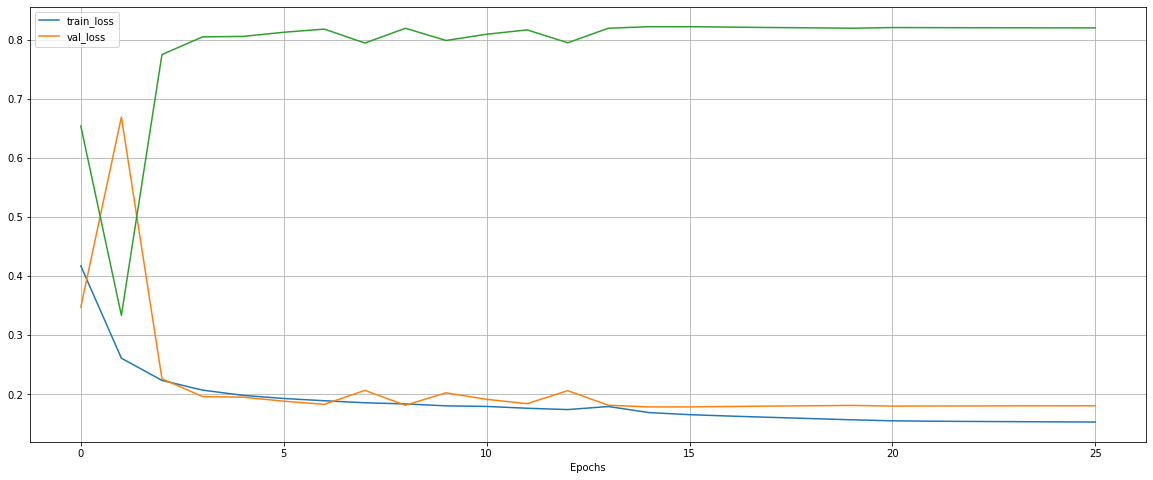

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(history_df.loss)
plt.plot(history_df.val_loss)
plt.plot(history_df.val_dice_coef)
plt.legend(["train_loss", "val_loss"])
plt.grid("both")
plt.xlabel("Epochs")


In [ ]:
H = 512
W = 512

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
#    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((ori_x.shape[0], 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255
    print(ori_x.shape, line.shape, ori_y.shape, line.shape, y_pred.shape)

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
!ls

augmented    images	  predictions_np  results_reconstructed  trained_models
groundtruth  predictions  results	  split_2


In [ ]:
split_name = "split_2"

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
split="test"
f1_scores = []
threshold = 0.5
num_epchs_completed = 20

model_dir = f"{root_path}/trained_models/"
print("Model dir", model_dir)
data_path = f"{root_path}/{split_name}/{split}"
num_test_images = len(os.listdir(f"{data_path}/mask"))
print(f"Number of images in split {split} : {num_test_images} ")

# Prediction for patches
results_path = f"{root_path}/results_recomputed/"
prediction_path = f"{root_path}/predictions_recomputed/"
prediction_np_path = f"{root_path}/predictions_np_recomputed/"
create_dir(prediction_path)
create_dir(prediction_np_path)
create_dir(results_path)

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model_path = os.path.join(f"{model_dir}", f"model.h5")
model = load_model(model_path, compile=False)


# Predict and compute metrics at patch level
df, score = compute_metrics(data_path=data_path,
                            results_path=results_path,
                            threshold=0.5, 
                            model=model,
                            prediction_np_path=prediction_np_path )

# Reconstruct full image 

# Reconstructing Patches
predicted_patches_dict = create_patches_dictionary(prediction_np_path=prediction_np_path)
metadata_test_df_filename = f"{root_path}/{split_name}/image_patches_512_512_test.csv"

metadata_test_df = pd.read_csv(metadata_test_df_filename)
reconstructed_predictions_path = f"reconstructed/{split}/predictions_reconstructed_recomputed/"
create_dir(reconstructed_predictions_path)
reconstruct_patches(predicted_patches_dict,
                    metadata_test_df,
                    reconstructed_predictions_path,
                    mfactor=255
                    )

test_full_image_path = f"{root_path}/{split_name}/reconstructed/{split}"
results_path_reconstructed = f"{root_path}/{split_name}/results_reconstructed_recomputed/"
create_dir(results_path_reconstructed)
df, score = compute_metrics(data_path=test_full_image_path,
                results_path=results_path_reconstructed,
                threshold=threshold,
                predictions_path=reconstructed_predictions_path)
f1_scores.append(score[1])



Model dir /content/datasets/hrf_512_512_dice_loss_hvr_0_3_feb_3//trained_models/
Number of images in split test : 490 
Threshold 0.5


  0%|          | 0/490 [00:00<?, ?it/s]

_02_g_0
(512, 512, 1) 1.0 2.7056296e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  0%|          | 1/490 [00:00<06:39,  1.22it/s]

_02_g_1
(512, 512, 1) 1.0 1.914536e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  0%|          | 2/490 [00:01<05:07,  1.59it/s]

_02_g_10
(512, 512, 1) 1.0 8.456697e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  1%|          | 3/490 [00:01<04:38,  1.75it/s]

_02_g_11
(512, 512, 1) 1.0 2.633566e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  1%|          | 4/490 [00:02<04:25,  1.83it/s]

_02_g_12
(512, 512, 1) 1.0 5.466589e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  1%|          | 5/490 [00:02<04:18,  1.88it/s]

_02_g_13
(512, 512, 1) 1.0 6.888694e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  1%|          | 6/490 [00:03<04:13,  1.91it/s]

_02_g_14
(512, 512, 1) 1.0 6.8205594e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  1%|▏         | 7/490 [00:03<04:11,  1.92it/s]

_02_g_15
(512, 512, 1) 1.0 1.9231108e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  2%|▏         | 8/490 [00:04<04:12,  1.91it/s]

_02_g_16
(512, 512, 1) 1.0 9.313808e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  2%|▏         | 9/490 [00:04<04:06,  1.95it/s]

_02_g_17
(512, 512, 1) 1.0 1.4906341e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  2%|▏         | 10/490 [00:05<04:04,  1.96it/s]

_02_g_18
(512, 512, 1) 1.0 6.3653533e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  2%|▏         | 11/490 [00:05<04:04,  1.96it/s]

_02_g_19
(512, 512, 1) 1.0 4.2712682e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  2%|▏         | 12/490 [00:06<04:07,  1.93it/s]

_02_g_2
(512, 512, 1) 1.0 5.137722e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  3%|▎         | 13/490 [00:06<04:04,  1.95it/s]

_02_g_20
(512, 512, 1) 1.0 4.810768e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  3%|▎         | 14/490 [00:07<04:05,  1.94it/s]

_02_g_21
(512, 512, 1) 1.0 2.4965757e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  3%|▎         | 15/490 [00:07<04:07,  1.92it/s]

_02_g_22
(512, 512, 1) 1.0 5.0355203e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  3%|▎         | 16/490 [00:08<04:05,  1.93it/s]

_02_g_23
(512, 512, 1) 1.0 8.623802e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  3%|▎         | 17/490 [00:09<04:05,  1.93it/s]

_02_g_24
(512, 512, 1) 1.0 8.6805716e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  4%|▎         | 18/490 [00:09<04:02,  1.94it/s]

_02_g_25
(512, 512, 1) 1.0 5.793952e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  4%|▍         | 19/490 [00:10<04:04,  1.92it/s]

_02_g_26
(512, 512, 1) 1.0 5.759465e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  4%|▍         | 20/490 [00:10<04:09,  1.89it/s]

_02_g_27
(512, 512, 1) 1.0 3.9536505e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  4%|▍         | 21/490 [00:11<04:07,  1.90it/s]

_02_g_28
(512, 512, 1) 1.0 3.6671179e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  4%|▍         | 22/490 [00:11<04:01,  1.94it/s]

_02_g_29
(512, 512, 1) 1.0 2.3070265e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  5%|▍         | 23/490 [00:12<04:00,  1.94it/s]

_02_g_3
(512, 512, 1) 1.0 6.024297e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  5%|▍         | 24/490 [00:12<03:58,  1.96it/s]

_02_g_30
(512, 512, 1) 1.0 5.8333944e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  5%|▌         | 25/490 [00:13<03:56,  1.97it/s]

_02_g_31
(512, 512, 1) 1.0 2.9561224e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  5%|▌         | 26/490 [00:13<03:53,  1.98it/s]

_02_g_32
(512, 512, 1) 1.0 6.257387e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  6%|▌         | 27/490 [00:14<03:53,  1.98it/s]

_02_g_33
(512, 512, 1) 1.0 7.4994887e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  6%|▌         | 28/490 [00:14<03:51,  1.99it/s]

_02_g_34
(512, 512, 1) 1.0 7.689529e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  6%|▌         | 29/490 [00:15<03:50,  2.00it/s]

_02_g_4
(512, 512, 1) 1.0 3.362554e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  6%|▌         | 30/490 [00:15<03:50,  2.00it/s]

_02_g_5
(512, 512, 1) 1.0 3.9088786e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  6%|▋         | 31/490 [00:16<03:49,  2.00it/s]

_02_g_6
(512, 512, 1) 1.0 2.7154497e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  7%|▋         | 32/490 [00:16<03:47,  2.01it/s]

_02_g_7
(512, 512, 1) 1.0 4.6148818e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  7%|▋         | 33/490 [00:17<03:47,  2.00it/s]

_02_g_8
(512, 512, 1) 1.0 1.0523604e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  7%|▋         | 34/490 [00:17<03:47,  2.00it/s]

_02_g_9
(512, 512, 1) 1.0 7.7229663e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  7%|▋         | 35/490 [00:18<03:47,  2.00it/s]

_03_h_0
(512, 512, 1) 1.0 1.7773538e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  7%|▋         | 36/490 [00:18<03:45,  2.01it/s]

_03_h_1
(512, 512, 1) 1.0 9.946203e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  8%|▊         | 37/490 [00:19<03:45,  2.01it/s]

_03_h_10
(512, 512, 1) 1.0 1.0363217e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  8%|▊         | 38/490 [00:19<03:45,  2.00it/s]

_03_h_11
(512, 512, 1) 1.0 1.4869908e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  8%|▊         | 39/490 [00:20<03:46,  1.99it/s]

_03_h_12
(512, 512, 1) 1.0 5.82595e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  8%|▊         | 40/490 [00:20<03:47,  1.98it/s]

_03_h_13
(512, 512, 1) 1.0 3.4056911e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  8%|▊         | 41/490 [00:21<03:46,  1.98it/s]

_03_h_14
(512, 512, 1) 1.0 1.3734464e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  9%|▊         | 42/490 [00:21<03:45,  1.99it/s]

_03_h_15
(512, 512, 1) 1.0 6.853212e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  9%|▉         | 43/490 [00:22<03:46,  1.98it/s]

_03_h_16
(512, 512, 1) 1.0 9.0714735e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  9%|▉         | 44/490 [00:22<03:45,  1.98it/s]

_03_h_17
(512, 512, 1) 1.0 2.4019528e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  9%|▉         | 45/490 [00:23<03:45,  1.98it/s]

_03_h_18
(512, 512, 1) 1.0 8.6342123e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


  9%|▉         | 46/490 [00:23<03:45,  1.97it/s]

_03_h_19
(512, 512, 1) 1.0 5.917521e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 10%|▉         | 47/490 [00:24<03:44,  1.97it/s]

_03_h_2
(512, 512, 1) 1.0 5.7579655e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 10%|▉         | 48/490 [00:24<03:42,  1.99it/s]

_03_h_20
(512, 512, 1) 1.0 7.484656e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 10%|█         | 49/490 [00:25<03:46,  1.95it/s]

_03_h_21
(512, 512, 1) 1.0 1.415731e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 10%|█         | 50/490 [00:25<03:48,  1.93it/s]

_03_h_22
(512, 512, 1) 1.0 9.3320523e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 10%|█         | 51/490 [00:26<03:48,  1.92it/s]

_03_h_23
(512, 512, 1) 1.0 1.1295089e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 11%|█         | 52/490 [00:26<03:46,  1.93it/s]

_03_h_24
(512, 512, 1) 1.0 1.8810553e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 11%|█         | 53/490 [00:27<03:45,  1.94it/s]

_03_h_25
(512, 512, 1) 1.0 1.5445839e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 11%|█         | 54/490 [00:27<03:45,  1.93it/s]

_03_h_26
(512, 512, 1) 1.0 1.3649379e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 11%|█         | 55/490 [00:28<03:44,  1.94it/s]

_03_h_27
(512, 512, 1) 1.0 2.4880023e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 11%|█▏        | 56/490 [00:28<03:42,  1.95it/s]

_03_h_28
(512, 512, 1) 1.0 7.2490984e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 12%|█▏        | 57/490 [00:29<03:40,  1.97it/s]

_03_h_29
(512, 512, 1) 1.0 1.9552251e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 12%|█▏        | 58/490 [00:29<03:39,  1.97it/s]

_03_h_3
(512, 512, 1) 1.0 8.040584e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 12%|█▏        | 59/490 [00:30<03:38,  1.97it/s]

_03_h_30
(512, 512, 1) 1.0 9.254539e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 12%|█▏        | 60/490 [00:30<03:36,  1.99it/s]

_03_h_31
(512, 512, 1) 1.0 1.7732701e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 12%|█▏        | 61/490 [00:31<03:37,  1.98it/s]

_03_h_32
(512, 512, 1) 1.0 1.5776006e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 13%|█▎        | 62/490 [00:31<03:52,  1.84it/s]

_03_h_33
(512, 512, 1) 1.0 2.7375643e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 13%|█▎        | 63/490 [00:32<03:52,  1.84it/s]

_03_h_34
(512, 512, 1) 1.0 6.6833277e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 13%|█▎        | 64/490 [00:33<03:45,  1.89it/s]

_03_h_4
(512, 512, 1) 1.0 7.6038054e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 13%|█▎        | 65/490 [00:33<03:40,  1.92it/s]

_03_h_5
(512, 512, 1) 1.0 1.1103326e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 13%|█▎        | 66/490 [00:34<03:38,  1.94it/s]

_03_h_6
(512, 512, 1) 1.0 1.6883847e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 14%|█▎        | 67/490 [00:34<03:38,  1.94it/s]

_03_h_7
(512, 512, 1) 1.0 1.3550355e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 14%|█▍        | 68/490 [00:35<03:40,  1.91it/s]

_03_h_8
(512, 512, 1) 1.0 4.8723433e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 14%|█▍        | 69/490 [00:35<03:39,  1.92it/s]

_03_h_9
(512, 512, 1) 1.0 5.2490316e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 14%|█▍        | 70/490 [00:36<03:40,  1.90it/s]

_05_dr_0
(512, 512, 1) 1.0 1.2640116e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 14%|█▍        | 71/490 [00:36<03:37,  1.93it/s]

_05_dr_1
(512, 512, 1) 1.0 6.910237e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 15%|█▍        | 72/490 [00:37<03:39,  1.90it/s]

_05_dr_10
(512, 512, 1) 1.0 1.3250632e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 15%|█▍        | 73/490 [00:37<03:37,  1.92it/s]

_05_dr_11
(512, 512, 1) 1.0 1.2423116e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 15%|█▌        | 74/490 [00:38<03:34,  1.94it/s]

_05_dr_12
(512, 512, 1) 1.0 3.7205703e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 15%|█▌        | 75/490 [00:38<03:32,  1.95it/s]

_05_dr_13
(512, 512, 1) 1.0 1.4563315e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 16%|█▌        | 76/490 [00:39<03:35,  1.93it/s]

_05_dr_14
(512, 512, 1) 1.0 1.0360194e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 16%|█▌        | 77/490 [00:39<03:31,  1.95it/s]

_05_dr_15
(512, 512, 1) 1.0 2.5371384e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 16%|█▌        | 78/490 [00:40<03:30,  1.96it/s]

_05_dr_16
(512, 512, 1) 1.0 6.384809e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 16%|█▌        | 79/490 [00:40<03:29,  1.97it/s]

_05_dr_17
(512, 512, 1) 1.0 9.759633e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 16%|█▋        | 80/490 [00:41<03:28,  1.97it/s]

_05_dr_18
(512, 512, 1) 1.0 9.328368e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 17%|█▋        | 81/490 [00:41<03:30,  1.94it/s]

_05_dr_19
(512, 512, 1) 1.0 6.0449634e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 17%|█▋        | 82/490 [00:42<03:29,  1.95it/s]

_05_dr_2
(512, 512, 1) 1.0 7.118354e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 17%|█▋        | 83/490 [00:42<03:28,  1.95it/s]

_05_dr_20
(512, 512, 1) 1.0 8.509671e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 17%|█▋        | 84/490 [00:43<03:27,  1.96it/s]

_05_dr_21
(512, 512, 1) 1.0 3.0398535e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 17%|█▋        | 85/490 [00:43<03:26,  1.96it/s]

_05_dr_22
(512, 512, 1) 1.0 1.5711925e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 18%|█▊        | 86/490 [00:44<03:30,  1.92it/s]

_05_dr_23
(512, 512, 1) 1.0 1.1185163e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 18%|█▊        | 87/490 [00:44<03:27,  1.94it/s]

_05_dr_24
(512, 512, 1) 1.0 1.0418095e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 18%|█▊        | 88/490 [00:45<03:28,  1.93it/s]

_05_dr_25
(512, 512, 1) 1.0 1.3369635e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 18%|█▊        | 89/490 [00:45<03:30,  1.90it/s]

_05_dr_26
(512, 512, 1) 1.0 1.1477534e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 18%|█▊        | 90/490 [00:46<03:29,  1.91it/s]

_05_dr_27
(512, 512, 1) 1.0 7.5907275e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 19%|█▊        | 91/490 [00:46<03:29,  1.91it/s]

_05_dr_28
(512, 512, 1) 1.0 5.2324112e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 19%|█▉        | 92/490 [00:47<03:27,  1.92it/s]

_05_dr_29
(512, 512, 1) 1.0 5.236377e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 19%|█▉        | 93/490 [00:47<03:26,  1.92it/s]

_05_dr_3
(512, 512, 1) 1.0 7.031432e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 19%|█▉        | 94/490 [00:48<03:26,  1.92it/s]

_05_dr_30
(512, 512, 1) 1.0 1.6160475e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 19%|█▉        | 95/490 [00:49<03:23,  1.94it/s]

_05_dr_31
(512, 512, 1) 1.0 7.3732565e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 20%|█▉        | 96/490 [00:49<03:20,  1.97it/s]

_05_dr_32
(512, 512, 1) 1.0 1.4338325e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 20%|█▉        | 97/490 [00:50<03:18,  1.98it/s]

_05_dr_33
(512, 512, 1) 1.0 9.47563e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 20%|██        | 98/490 [00:50<03:17,  1.98it/s]

_05_dr_34
(512, 512, 1) 1.0 3.270474e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 20%|██        | 99/490 [00:51<03:16,  1.99it/s]

_05_dr_4
(512, 512, 1) 1.0 1.0364581e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 20%|██        | 100/490 [00:51<03:14,  2.00it/s]

_05_dr_5
(512, 512, 1) 1.0 7.5705856e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 21%|██        | 101/490 [00:52<03:15,  1.99it/s]

_05_dr_6
(512, 512, 1) 1.0 1.0684821e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 21%|██        | 102/490 [00:52<03:16,  1.97it/s]

_05_dr_7
(512, 512, 1) 1.0 8.2375664e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 21%|██        | 103/490 [00:53<03:16,  1.97it/s]

_05_dr_8
(512, 512, 1) 1.0 2.276102e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 21%|██        | 104/490 [00:53<03:16,  1.97it/s]

_05_dr_9
(512, 512, 1) 1.0 1.3665542e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 21%|██▏       | 105/490 [00:54<03:14,  1.97it/s]

_05_g_0
(512, 512, 1) 1.0 2.3099817e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 22%|██▏       | 106/490 [00:54<03:13,  1.98it/s]

_05_g_1
(512, 512, 1) 1.0 1.2549158e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 22%|██▏       | 107/490 [00:55<03:12,  1.99it/s]

_05_g_10
(512, 512, 1) 1.0 6.4044576e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 22%|██▏       | 108/490 [00:55<03:13,  1.98it/s]

_05_g_11
(512, 512, 1) 1.0 4.4571797e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 22%|██▏       | 109/490 [00:56<03:18,  1.92it/s]

_05_g_12
(512, 512, 1) 1.0 1.1539028e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 22%|██▏       | 110/490 [00:56<03:16,  1.93it/s]

_05_g_13
(512, 512, 1) 1.0 3.402898e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 23%|██▎       | 111/490 [00:57<03:15,  1.94it/s]

_05_g_14
(512, 512, 1) 1.0 1.8919252e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 23%|██▎       | 112/490 [00:57<03:12,  1.96it/s]

_05_g_15
(512, 512, 1) 1.0 4.4850057e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 23%|██▎       | 113/490 [00:58<03:10,  1.97it/s]

_05_g_16
(512, 512, 1) 1.0 5.4521456e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 23%|██▎       | 114/490 [00:58<03:10,  1.98it/s]

_05_g_17
(512, 512, 1) 1.0 1.8187933e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 23%|██▎       | 115/490 [00:59<03:17,  1.90it/s]

_05_g_18
(512, 512, 1) 1.0 8.231747e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 24%|██▎       | 116/490 [00:59<03:22,  1.85it/s]

_05_g_19
(512, 512, 1) 1.0 1.3908661e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 24%|██▍       | 117/490 [01:00<03:26,  1.81it/s]

_05_g_2
(512, 512, 1) 1.0 2.080545e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 24%|██▍       | 118/490 [01:00<03:27,  1.79it/s]

_05_g_20
(512, 512, 1) 1.0 4.5158006e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 24%|██▍       | 119/490 [01:01<03:29,  1.77it/s]

_05_g_21
(512, 512, 1) 1.0 6.492836e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 24%|██▍       | 120/490 [01:02<03:29,  1.76it/s]

_05_g_22
(512, 512, 1) 1.0 8.173368e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 25%|██▍       | 121/490 [01:02<03:30,  1.75it/s]

_05_g_23
(512, 512, 1) 1.0 4.076038e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 25%|██▍       | 122/490 [01:03<03:27,  1.78it/s]

_05_g_24
(512, 512, 1) 1.0 3.9746817e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 25%|██▌       | 123/490 [01:03<03:22,  1.82it/s]

_05_g_25
(512, 512, 1) 1.0 4.1796804e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 25%|██▌       | 124/490 [01:04<03:17,  1.85it/s]

_05_g_26
(512, 512, 1) 1.0 3.287293e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 26%|██▌       | 125/490 [01:04<03:12,  1.89it/s]

_05_g_27
(512, 512, 1) 1.0 7.2530764e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 26%|██▌       | 126/490 [01:05<03:09,  1.92it/s]

_05_g_28
(512, 512, 1) 0.00058721576 5.081735e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 26%|██▌       | 127/490 [01:05<03:06,  1.95it/s]

_05_g_29
(512, 512, 1) 1.0 8.045208e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 26%|██▌       | 128/490 [01:06<03:05,  1.95it/s]

_05_g_3
(512, 512, 1) 1.0 2.9118218e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 26%|██▋       | 129/490 [01:06<03:03,  1.97it/s]

_05_g_30
(512, 512, 1) 1.0 3.9152286e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 27%|██▋       | 130/490 [01:07<03:02,  1.98it/s]

_05_g_31
(512, 512, 1) 1.0 4.6358386e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 27%|██▋       | 131/490 [01:07<03:00,  1.99it/s]

_05_g_32
(512, 512, 1) 1.0 7.576834e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 27%|██▋       | 132/490 [01:08<03:00,  1.99it/s]

_05_g_33
(512, 512, 1) 1.0 4.5045354e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 27%|██▋       | 133/490 [01:08<02:59,  1.99it/s]

_05_g_34
(512, 512, 1) 1.0 5.4067277e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 27%|██▋       | 134/490 [01:09<02:58,  2.00it/s]

_05_g_4
(512, 512, 1) 1.0 4.035965e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 28%|██▊       | 135/490 [01:09<02:58,  1.99it/s]

_05_g_5
(512, 512, 1) 1.0 8.302752e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 28%|██▊       | 136/490 [01:10<02:59,  1.97it/s]

_05_g_6
(512, 512, 1) 1.0 8.0168473e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 28%|██▊       | 137/490 [01:10<02:57,  1.99it/s]

_05_g_7
(512, 512, 1) 1.0 4.871219e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 28%|██▊       | 138/490 [01:11<02:56,  2.00it/s]

_05_g_8
(512, 512, 1) 1.0 9.06714e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 28%|██▊       | 139/490 [01:11<02:55,  2.00it/s]

_05_g_9
(512, 512, 1) 1.0 3.586014e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 29%|██▊       | 140/490 [01:12<02:55,  1.99it/s]

_06_g_0
(512, 512, 1) 1.0 3.0671276e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 29%|██▉       | 141/490 [01:12<02:57,  1.97it/s]

_06_g_1
(512, 512, 1) 1.0 5.156812e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 29%|██▉       | 142/490 [01:13<03:00,  1.93it/s]

_06_g_10
(512, 512, 1) 1.0 7.170176e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 29%|██▉       | 143/490 [01:13<03:00,  1.92it/s]

_06_g_11
(512, 512, 1) 1.0 6.011115e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 29%|██▉       | 144/490 [01:14<03:00,  1.92it/s]

_06_g_12
(512, 512, 1) 1.0 5.92663e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 30%|██▉       | 145/490 [01:14<02:58,  1.93it/s]

_06_g_13
(512, 512, 1) 1.0 1.1374528e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 30%|██▉       | 146/490 [01:15<02:56,  1.95it/s]

_06_g_14
(512, 512, 1) 1.0 1.6776838e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 30%|███       | 147/490 [01:15<02:56,  1.94it/s]

_06_g_15
(512, 512, 1) 1.0 5.369523e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 30%|███       | 148/490 [01:16<02:56,  1.94it/s]

_06_g_16
(512, 512, 1) 1.0 2.6804017e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 30%|███       | 149/490 [01:16<02:55,  1.94it/s]

_06_g_17
(512, 512, 1) 1.0 8.679578e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 31%|███       | 150/490 [01:17<02:54,  1.95it/s]

_06_g_18
(512, 512, 1) 1.0 4.0138207e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 31%|███       | 151/490 [01:17<02:54,  1.94it/s]

_06_g_19
(512, 512, 1) 1.0 2.626616e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 31%|███       | 152/490 [01:18<02:53,  1.95it/s]

_06_g_2
(512, 512, 1) 1.0 2.3031247e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 31%|███       | 153/490 [01:18<02:51,  1.96it/s]

_06_g_20
(512, 512, 1) 1.0 1.4093594e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 31%|███▏      | 154/490 [01:19<02:50,  1.97it/s]

_06_g_21
(512, 512, 1) 1.0 3.424261e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 32%|███▏      | 155/490 [01:19<02:48,  1.98it/s]

_06_g_22
(512, 512, 1) 1.0 5.5065954e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 32%|███▏      | 156/490 [01:20<02:48,  1.98it/s]

_06_g_23
(512, 512, 1) 1.0 3.9772374e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 32%|███▏      | 157/490 [01:21<02:49,  1.97it/s]

_06_g_24
(512, 512, 1) 1.0 5.965661e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 32%|███▏      | 158/490 [01:21<02:53,  1.92it/s]

_06_g_25
(512, 512, 1) 1.0 1.8519101e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 32%|███▏      | 159/490 [01:22<02:53,  1.90it/s]

_06_g_26
(512, 512, 1) 1.0 2.750321e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 33%|███▎      | 160/490 [01:22<02:54,  1.89it/s]

_06_g_27
(512, 512, 1) 1.0 1.2654724e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 33%|███▎      | 161/490 [01:23<02:53,  1.89it/s]

_06_g_28
(512, 512, 1) 1.0 3.4843372e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 33%|███▎      | 162/490 [01:23<02:54,  1.88it/s]

_06_g_29
(512, 512, 1) 1.0 3.9540956e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 33%|███▎      | 163/490 [01:24<02:52,  1.90it/s]

_06_g_3
(512, 512, 1) 1.0 3.9014415e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 33%|███▎      | 164/490 [01:24<02:49,  1.92it/s]

_06_g_30
(512, 512, 1) 1.0 5.211378e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 34%|███▎      | 165/490 [01:25<02:48,  1.93it/s]

_06_g_31
(512, 512, 1) 1.0 6.97646e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 34%|███▍      | 166/490 [01:25<02:46,  1.94it/s]

_06_g_32
(512, 512, 1) 1.0 4.009968e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 34%|███▍      | 167/490 [01:26<02:45,  1.95it/s]

_06_g_33
(512, 512, 1) 1.0 1.1665619e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 34%|███▍      | 168/490 [01:26<02:44,  1.96it/s]

_06_g_34
(512, 512, 1) 1.0 1.5711189e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 34%|███▍      | 169/490 [01:27<02:42,  1.98it/s]

_06_g_4
(512, 512, 1) 1.0 3.795968e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 35%|███▍      | 170/490 [01:27<02:43,  1.96it/s]

_06_g_5
(512, 512, 1) 1.0 1.8839314e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 35%|███▍      | 171/490 [01:28<02:42,  1.96it/s]

_06_g_6
(512, 512, 1) 1.0 3.7859131e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 35%|███▌      | 172/490 [01:28<02:41,  1.97it/s]

_06_g_7
(512, 512, 1) 1.0 6.156652e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 35%|███▌      | 173/490 [01:29<02:40,  1.97it/s]

_06_g_8
(512, 512, 1) 1.0 5.7886666e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 36%|███▌      | 174/490 [01:29<02:40,  1.97it/s]

_06_g_9
(512, 512, 1) 1.0 7.5119584e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 36%|███▌      | 175/490 [01:30<02:39,  1.98it/s]

_08_dr_0
(512, 512, 1) 0.9522638 1.8675496e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 36%|███▌      | 176/490 [01:30<02:36,  2.00it/s]

_08_dr_1
(512, 512, 1) 1.0 2.678835e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 36%|███▌      | 177/490 [01:31<02:35,  2.01it/s]

_08_dr_10
(512, 512, 1) 1.0 1.3715284e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 36%|███▋      | 178/490 [01:31<02:37,  1.99it/s]

_08_dr_11
(512, 512, 1) 1.0 2.7330776e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 37%|███▋      | 179/490 [01:32<02:35,  2.00it/s]

_08_dr_12
(512, 512, 1) 1.0 2.3870356e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 37%|███▋      | 180/490 [01:32<02:35,  1.99it/s]

_08_dr_13
(512, 512, 1) 1.0 7.3119713e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 37%|███▋      | 181/490 [01:33<02:35,  1.99it/s]

_08_dr_14
(512, 512, 1) 1.0 9.117583e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 37%|███▋      | 182/490 [01:33<02:35,  1.99it/s]

_08_dr_15
(512, 512, 1) 1.0 2.9214345e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 37%|███▋      | 183/490 [01:34<02:35,  1.98it/s]

_08_dr_16
(512, 512, 1) 1.0 8.148947e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 38%|███▊      | 184/490 [01:34<02:34,  1.98it/s]

_08_dr_17
(512, 512, 1) 1.0 8.123542e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 38%|███▊      | 185/490 [01:35<02:34,  1.98it/s]

_08_dr_18
(512, 512, 1) 1.0 1.7480875e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 38%|███▊      | 186/490 [01:35<02:33,  1.98it/s]

_08_dr_19
(512, 512, 1) 1.0 1.5715251e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 38%|███▊      | 187/490 [01:36<02:33,  1.97it/s]

_08_dr_2
(512, 512, 1) 1.0 3.2170615e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 38%|███▊      | 188/490 [01:36<02:33,  1.97it/s]

_08_dr_20
(512, 512, 1) 1.0 3.2433448e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 39%|███▊      | 189/490 [01:37<02:32,  1.98it/s]

_08_dr_21
(512, 512, 1) 1.0 9.859116e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 39%|███▉      | 190/490 [01:37<02:31,  1.98it/s]

_08_dr_22
(512, 512, 1) 1.0 1.768383e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 39%|███▉      | 191/490 [01:38<02:31,  1.97it/s]

_08_dr_23
(512, 512, 1) 1.0 1.1673193e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 39%|███▉      | 192/490 [01:38<02:30,  1.98it/s]

_08_dr_24
(512, 512, 1) 1.0 2.0881282e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 39%|███▉      | 193/490 [01:39<02:30,  1.97it/s]

_08_dr_25
(512, 512, 1) 1.0 1.277391e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 40%|███▉      | 194/490 [01:39<02:30,  1.97it/s]

_08_dr_26
(512, 512, 1) 1.0 3.1061904e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 40%|███▉      | 195/490 [01:40<02:30,  1.96it/s]

_08_dr_27
(512, 512, 1) 1.0 8.556178e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 40%|████      | 196/490 [01:40<02:29,  1.97it/s]

_08_dr_28
(512, 512, 1) 1.0 2.0508124e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 40%|████      | 197/490 [01:41<02:27,  1.99it/s]

_08_dr_29
(512, 512, 1) 1.0 2.0442847e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 40%|████      | 198/490 [01:41<02:26,  1.99it/s]

_08_dr_3
(512, 512, 1) 1.0 1.98267e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 41%|████      | 199/490 [01:42<02:27,  1.97it/s]

_08_dr_30
(512, 512, 1) 1.0 2.0557157e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 41%|████      | 200/490 [01:42<02:29,  1.94it/s]

_08_dr_31
(512, 512, 1) 1.0 1.3426258e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 41%|████      | 201/490 [01:43<02:27,  1.96it/s]

_08_dr_32
(512, 512, 1) 1.0 1.9914059e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 41%|████      | 202/490 [01:43<02:26,  1.97it/s]

_08_dr_33
(512, 512, 1) 1.0 5.00267e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 41%|████▏     | 203/490 [01:44<02:26,  1.97it/s]

_08_dr_34
(512, 512, 1) 1.0 2.0280597e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 42%|████▏     | 204/490 [01:44<02:24,  1.97it/s]

_08_dr_4
(512, 512, 1) 1.0 3.7385607e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 42%|████▏     | 205/490 [01:45<02:24,  1.97it/s]

_08_dr_5
(512, 512, 1) 1.0 6.633137e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 42%|████▏     | 206/490 [01:45<02:24,  1.96it/s]

_08_dr_6
(512, 512, 1) 1.0 1.5433235e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 42%|████▏     | 207/490 [01:46<02:24,  1.96it/s]

_08_dr_7
(512, 512, 1) 1.0 7.030474e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 42%|████▏     | 208/490 [01:47<02:23,  1.97it/s]

_08_dr_8
(512, 512, 1) 1.0 2.0485038e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 43%|████▎     | 209/490 [01:47<02:24,  1.94it/s]

_08_dr_9
(512, 512, 1) 1.0 1.5378505e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 43%|████▎     | 210/490 [01:48<02:26,  1.91it/s]

_08_g_0
(512, 512, 1) 1.0 6.3639936e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 43%|████▎     | 211/490 [01:48<02:26,  1.91it/s]

_08_g_1
(512, 512, 1) 1.0 3.2313906e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 43%|████▎     | 212/490 [01:49<02:26,  1.90it/s]

_08_g_10
(512, 512, 1) 1.0 4.5001727e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 43%|████▎     | 213/490 [01:49<02:26,  1.89it/s]

_08_g_11
(512, 512, 1) 1.0 1.6146365e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 44%|████▎     | 214/490 [01:50<02:24,  1.90it/s]

_08_g_12
(512, 512, 1) 1.0 2.879595e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 44%|████▍     | 215/490 [01:50<02:23,  1.91it/s]

_08_g_13
(512, 512, 1) 1.0 3.2958843e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 44%|████▍     | 216/490 [01:51<02:21,  1.94it/s]

_08_g_14
(512, 512, 1) 1.0 4.7146165e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 44%|████▍     | 217/490 [01:51<02:20,  1.95it/s]

_08_g_15
(512, 512, 1) 1.0 3.3023503e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 44%|████▍     | 218/490 [01:52<02:19,  1.94it/s]

_08_g_16
(512, 512, 1) 1.0 7.196758e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 45%|████▍     | 219/490 [01:52<02:18,  1.95it/s]

_08_g_17
(512, 512, 1) 1.0 4.148352e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 45%|████▍     | 220/490 [01:53<02:18,  1.95it/s]

_08_g_18
(512, 512, 1) 1.0 3.0033937e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 45%|████▌     | 221/490 [01:53<02:17,  1.96it/s]

_08_g_19
(512, 512, 1) 1.0 1.212181e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 45%|████▌     | 222/490 [01:54<02:17,  1.95it/s]

_08_g_2
(512, 512, 1) 1.0 2.4012465e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 46%|████▌     | 223/490 [01:54<02:15,  1.97it/s]

_08_g_20
(512, 512, 1) 1.0 3.4616386e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 46%|████▌     | 224/490 [01:55<02:15,  1.96it/s]

_08_g_21
(512, 512, 1) 1.0 6.1198136e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 46%|████▌     | 225/490 [01:55<02:14,  1.97it/s]

_08_g_22
(512, 512, 1) 1.0 1.5837418e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 46%|████▌     | 226/490 [01:56<02:13,  1.97it/s]

_08_g_23
(512, 512, 1) 1.0 5.1262737e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 46%|████▋     | 227/490 [01:56<02:13,  1.97it/s]

_08_g_24
(512, 512, 1) 1.0 3.709456e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 47%|████▋     | 228/490 [01:57<02:14,  1.95it/s]

_08_g_25
(512, 512, 1) 1.0 3.4925802e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 47%|████▋     | 229/490 [01:57<02:13,  1.95it/s]

_08_g_26
(512, 512, 1) 1.0 4.34166e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 47%|████▋     | 230/490 [01:58<02:14,  1.93it/s]

_08_g_27
(512, 512, 1) 1.0 4.647179e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 47%|████▋     | 231/490 [01:58<02:12,  1.95it/s]

_08_g_28
(512, 512, 1) 1.0 2.90358e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 47%|████▋     | 232/490 [01:59<02:12,  1.95it/s]

_08_g_29
(512, 512, 1) 1.0 8.152582e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 48%|████▊     | 233/490 [01:59<02:12,  1.94it/s]

_08_g_3
(512, 512, 1) 1.0 2.5649388e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 48%|████▊     | 234/490 [02:00<02:12,  1.93it/s]

_08_g_30
(512, 512, 1) 1.0 1.3850763e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 48%|████▊     | 235/490 [02:00<02:13,  1.91it/s]

_08_g_31
(512, 512, 1) 1.0 3.558732e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 48%|████▊     | 236/490 [02:01<02:14,  1.89it/s]

_08_g_32
(512, 512, 1) 1.0 5.905766e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 48%|████▊     | 237/490 [02:02<02:14,  1.89it/s]

_08_g_33
(512, 512, 1) 1.0 3.7852314e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 49%|████▊     | 238/490 [02:02<02:13,  1.89it/s]

_08_g_34
(512, 512, 1) 0.9999999 7.3269553e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 49%|████▉     | 239/490 [02:03<02:11,  1.91it/s]

_08_g_4
(512, 512, 1) 1.0 4.1751824e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 49%|████▉     | 240/490 [02:03<02:11,  1.91it/s]

_08_g_5
(512, 512, 1) 1.0 2.7209998e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 49%|████▉     | 241/490 [02:04<02:09,  1.92it/s]

_08_g_6
(512, 512, 1) 1.0 1.1063963e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 49%|████▉     | 242/490 [02:04<02:07,  1.95it/s]

_08_g_7
(512, 512, 1) 1.0 1.6748542e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 50%|████▉     | 243/490 [02:05<02:05,  1.96it/s]

_08_g_8
(512, 512, 1) 1.0 3.9815333e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 50%|████▉     | 244/490 [02:05<02:05,  1.96it/s]

_08_g_9
(512, 512, 1) 1.0 2.466329e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 50%|█████     | 245/490 [02:06<02:05,  1.96it/s]

_10_h_0
(512, 512, 1) 1.0 1.2087343e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 50%|█████     | 246/490 [02:06<02:04,  1.96it/s]

_10_h_1
(512, 512, 1) 1.0 4.116725e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 50%|█████     | 247/490 [02:07<02:03,  1.97it/s]

_10_h_10
(512, 512, 1) 1.0 6.2640083e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 51%|█████     | 248/490 [02:07<02:02,  1.97it/s]

_10_h_11
(512, 512, 1) 1.0 8.395873e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 51%|█████     | 249/490 [02:08<02:01,  1.98it/s]

_10_h_12
(512, 512, 1) 1.0 3.187895e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 51%|█████     | 250/490 [02:08<02:01,  1.97it/s]

_10_h_13
(512, 512, 1) 1.0 3.7869899e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 51%|█████     | 251/490 [02:09<02:00,  1.98it/s]

_10_h_14
(512, 512, 1) 1.0 1.3103391e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 51%|█████▏    | 252/490 [02:09<02:00,  1.98it/s]

_10_h_15
(512, 512, 1) 1.0 4.4629303e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 52%|█████▏    | 253/490 [02:10<01:59,  1.98it/s]

_10_h_16
(512, 512, 1) 1.0 1.1994075e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 52%|█████▏    | 254/490 [02:10<01:58,  1.99it/s]

_10_h_17
(512, 512, 1) 1.0 8.3724615e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 52%|█████▏    | 255/490 [02:11<01:58,  1.99it/s]

_10_h_18
(512, 512, 1) 1.0 5.956617e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 52%|█████▏    | 256/490 [02:11<01:58,  1.97it/s]

_10_h_19
(512, 512, 1) 1.0 6.3700475e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 52%|█████▏    | 257/490 [02:12<01:58,  1.97it/s]

_10_h_2
(512, 512, 1) 1.0 3.7862822e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 53%|█████▎    | 258/490 [02:12<01:57,  1.97it/s]

_10_h_20
(512, 512, 1) 1.0 1.1263808e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 53%|█████▎    | 259/490 [02:13<01:56,  1.98it/s]

_10_h_21
(512, 512, 1) 1.0 1.0424267e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 53%|█████▎    | 260/490 [02:13<01:55,  1.99it/s]

_10_h_22
(512, 512, 1) 1.0 3.0065172e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 53%|█████▎    | 261/490 [02:14<01:55,  1.99it/s]

_10_h_23
(512, 512, 1) 1.0 9.455031e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 53%|█████▎    | 262/490 [02:14<01:54,  1.99it/s]

_10_h_24
(512, 512, 1) 1.0 6.9181624e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 54%|█████▎    | 263/490 [02:15<01:54,  1.99it/s]

_10_h_25
(512, 512, 1) 1.0 6.6704064e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 54%|█████▍    | 264/490 [02:15<01:54,  1.98it/s]

_10_h_26
(512, 512, 1) 1.0 5.4641964e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 54%|█████▍    | 265/490 [02:16<01:55,  1.94it/s]

_10_h_27
(512, 512, 1) 1.0 8.217142e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 54%|█████▍    | 266/490 [02:16<01:54,  1.96it/s]

_10_h_28
(512, 512, 1) 1.0 5.4980233e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 54%|█████▍    | 267/490 [02:17<01:53,  1.97it/s]

_10_h_29
(512, 512, 1) 1.0 1.5425068e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 55%|█████▍    | 268/490 [02:17<01:52,  1.98it/s]

_10_h_3
(512, 512, 1) 1.0 7.3857694e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 55%|█████▍    | 269/490 [02:18<01:51,  1.99it/s]

_10_h_30
(512, 512, 1) 1.0 7.121688e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 55%|█████▌    | 270/490 [02:18<01:50,  2.00it/s]

_10_h_31
(512, 512, 1) 1.0 5.329399e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 55%|█████▌    | 271/490 [02:19<01:49,  2.00it/s]

_10_h_32
(512, 512, 1) 1.0 6.859306e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 56%|█████▌    | 272/490 [02:19<01:49,  1.99it/s]

_10_h_33
(512, 512, 1) 1.0 6.360499e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 56%|█████▌    | 273/490 [02:20<01:49,  1.99it/s]

_10_h_34
(512, 512, 1) 1.0 5.2161095e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 56%|█████▌    | 274/490 [02:20<01:47,  2.00it/s]

_10_h_4
(512, 512, 1) 1.0 4.0199117e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 56%|█████▌    | 275/490 [02:21<01:47,  2.01it/s]

_10_h_5
(512, 512, 1) 1.0 3.5535365e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 56%|█████▋    | 276/490 [02:21<01:46,  2.00it/s]

_10_h_6
(512, 512, 1) 1.0 1.4739212e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 57%|█████▋    | 277/490 [02:22<01:45,  2.01it/s]

_10_h_7
(512, 512, 1) 1.0 4.929486e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 57%|█████▋    | 278/490 [02:22<01:45,  2.02it/s]

_10_h_8
(512, 512, 1) 1.0 8.602454e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 57%|█████▋    | 279/490 [02:23<01:45,  2.01it/s]

_10_h_9
(512, 512, 1) 1.0 1.0973383e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 57%|█████▋    | 280/490 [02:23<01:45,  1.99it/s]

_11_dr_0
(512, 512, 1) 1.0 2.8526163e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 57%|█████▋    | 281/490 [02:24<01:44,  2.00it/s]

_11_dr_1
(512, 512, 1) 1.0 8.4754123e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 58%|█████▊    | 282/490 [02:24<01:43,  2.00it/s]

_11_dr_10
(512, 512, 1) 1.0 4.3380842e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 58%|█████▊    | 283/490 [02:25<01:43,  1.99it/s]

_11_dr_11
(512, 512, 1) 1.0 4.7688127e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 58%|█████▊    | 284/490 [02:25<01:43,  2.00it/s]

_11_dr_12
(512, 512, 1) 1.0 2.0757577e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 58%|█████▊    | 285/490 [02:26<01:43,  1.99it/s]

_11_dr_13
(512, 512, 1) 1.0 8.8135215e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 58%|█████▊    | 286/490 [02:26<01:42,  1.99it/s]

_11_dr_14
(512, 512, 1) 1.0 6.677834e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 59%|█████▊    | 287/490 [02:27<01:41,  1.99it/s]

_11_dr_15
(512, 512, 1) 1.0 4.3671741e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 59%|█████▉    | 288/490 [02:27<01:41,  1.98it/s]

_11_dr_16
(512, 512, 1) 1.0 9.2523413e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 59%|█████▉    | 289/490 [02:28<01:41,  1.98it/s]

_11_dr_17
(512, 512, 1) 1.0 5.018281e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 59%|█████▉    | 290/490 [02:28<01:40,  1.98it/s]

_11_dr_18
(512, 512, 1) 1.0 8.388286e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 59%|█████▉    | 291/490 [02:29<01:40,  1.98it/s]

_11_dr_19
(512, 512, 1) 1.0 2.564244e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 60%|█████▉    | 292/490 [02:29<01:40,  1.97it/s]

_11_dr_2
(512, 512, 1) 1.0 5.62151e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 60%|█████▉    | 293/490 [02:30<01:39,  1.98it/s]

_11_dr_20
(512, 512, 1) 1.0 7.5823635e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 60%|██████    | 294/490 [02:30<01:38,  1.99it/s]

_11_dr_21
(512, 512, 1) 1.0 7.097936e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 60%|██████    | 295/490 [02:31<01:37,  2.00it/s]

_11_dr_22
(512, 512, 1) 1.0 5.0545293e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 60%|██████    | 296/490 [02:31<01:37,  1.99it/s]

_11_dr_23
(512, 512, 1) 1.0 4.46914e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 61%|██████    | 297/490 [02:32<01:37,  1.99it/s]

_11_dr_24
(512, 512, 1) 1.0 7.871668e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 61%|██████    | 298/490 [02:32<01:36,  1.98it/s]

_11_dr_25
(512, 512, 1) 1.0 6.8188166e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 61%|██████    | 299/490 [02:33<01:36,  1.99it/s]

_11_dr_26
(512, 512, 1) 1.0 1.9379422e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 61%|██████    | 300/490 [02:33<01:35,  1.99it/s]

_11_dr_27
(512, 512, 1) 1.0 4.2000786e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 61%|██████▏   | 301/490 [02:34<01:34,  2.00it/s]

_11_dr_28
(512, 512, 1) 0.001004357 7.037166e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 62%|██████▏   | 302/490 [02:34<01:33,  2.01it/s]

_11_dr_29
(512, 512, 1) 1.0 6.195791e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 62%|██████▏   | 303/490 [02:35<01:33,  2.01it/s]

_11_dr_3
(512, 512, 1) 1.0 7.19382e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 62%|██████▏   | 304/490 [02:35<01:32,  2.00it/s]

_11_dr_30
(512, 512, 1) 1.0 6.0572665e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 62%|██████▏   | 305/490 [02:36<01:32,  2.01it/s]

_11_dr_31
(512, 512, 1) 1.0 6.632208e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 62%|██████▏   | 306/490 [02:36<01:31,  2.00it/s]

_11_dr_32
(512, 512, 1) 1.0 4.7954506e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 63%|██████▎   | 307/490 [02:37<01:31,  2.00it/s]

_11_dr_33
(512, 512, 1) 1.0 1.4843895e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 63%|██████▎   | 308/490 [02:37<01:30,  2.01it/s]

_11_dr_34
(512, 512, 1) 1.0 4.592145e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 63%|██████▎   | 309/490 [02:38<01:30,  1.99it/s]

_11_dr_4
(512, 512, 1) 1.0 1.0224632e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 63%|██████▎   | 310/490 [02:38<01:30,  2.00it/s]

_11_dr_5
(512, 512, 1) 1.0 1.2051166e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 63%|██████▎   | 311/490 [02:39<01:29,  1.99it/s]

_11_dr_6
(512, 512, 1) 1.0 4.004869e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 64%|██████▎   | 312/490 [02:39<01:29,  2.00it/s]

_11_dr_7
(512, 512, 1) 1.0 8.7503065e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 64%|██████▍   | 313/490 [02:40<01:29,  1.97it/s]

_11_dr_8
(512, 512, 1) 1.0 4.0820368e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 64%|██████▍   | 314/490 [02:40<01:28,  1.98it/s]

_11_dr_9
(512, 512, 1) 1.0 7.359642e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 64%|██████▍   | 315/490 [02:41<01:28,  1.99it/s]

_11_h_0
(512, 512, 1) 1.0 1.5509975e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 64%|██████▍   | 316/490 [02:41<01:26,  2.01it/s]

_11_h_1
(512, 512, 1) 1.0 3.3026996e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 65%|██████▍   | 317/490 [02:42<01:26,  2.01it/s]

_11_h_10
(512, 512, 1) 1.0 2.8875093e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 65%|██████▍   | 318/490 [02:42<01:25,  2.00it/s]

_11_h_11
(512, 512, 1) 1.0 1.620432e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 65%|██████▌   | 319/490 [02:43<01:27,  1.96it/s]

_11_h_12
(512, 512, 1) 1.0 1.9326783e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 65%|██████▌   | 320/490 [02:43<01:26,  1.96it/s]

_11_h_13
(512, 512, 1) 1.0 3.490733e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 66%|██████▌   | 321/490 [02:44<01:25,  1.97it/s]

_11_h_14
(512, 512, 1) 1.0 7.315424e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 66%|██████▌   | 322/490 [02:44<01:24,  1.98it/s]

_11_h_15
(512, 512, 1) 1.0 6.3094484e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 66%|██████▌   | 323/490 [02:45<01:24,  1.98it/s]

_11_h_16
(512, 512, 1) 1.0 7.3793416e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 66%|██████▌   | 324/490 [02:45<01:23,  1.98it/s]

_11_h_17
(512, 512, 1) 1.0 7.850025e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 66%|██████▋   | 325/490 [02:46<01:23,  1.98it/s]

_11_h_18
(512, 512, 1) 1.0 9.053523e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 67%|██████▋   | 326/490 [02:46<01:22,  1.99it/s]

_11_h_19
(512, 512, 1) 1.0 4.0148964e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 67%|██████▋   | 327/490 [02:47<01:21,  1.99it/s]

_11_h_2
(512, 512, 1) 1.0 5.158455e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 67%|██████▋   | 328/490 [02:47<01:21,  1.99it/s]

_11_h_20
(512, 512, 1) 1.0 9.969698e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 67%|██████▋   | 329/490 [02:48<01:20,  1.99it/s]

_11_h_21
(512, 512, 1) 1.0 1.4627872e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 67%|██████▋   | 330/490 [02:48<01:19,  2.01it/s]

_11_h_22
(512, 512, 1) 1.0 4.9649367e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 68%|██████▊   | 331/490 [02:49<01:20,  1.98it/s]

_11_h_23
(512, 512, 1) 1.0 1.1192781e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 68%|██████▊   | 332/490 [02:49<01:19,  1.98it/s]

_11_h_24
(512, 512, 1) 1.0 1.7697275e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 68%|██████▊   | 333/490 [02:50<01:18,  1.99it/s]

_11_h_25
(512, 512, 1) 1.0 1.7009437e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 68%|██████▊   | 334/490 [02:50<01:18,  1.99it/s]

_11_h_26
(512, 512, 1) 1.0 1.2754803e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 68%|██████▊   | 335/490 [02:51<01:17,  2.00it/s]

_11_h_27
(512, 512, 1) 1.0 2.3177802e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 69%|██████▊   | 336/490 [02:51<01:17,  2.00it/s]

_11_h_28
(512, 512, 1) 1.0 6.247237e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 69%|██████▉   | 337/490 [02:52<01:16,  2.00it/s]

_11_h_29
(512, 512, 1) 1.0 1.2763966e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 69%|██████▉   | 338/490 [02:52<01:15,  2.00it/s]

_11_h_3
(512, 512, 1) 1.0 1.0683201e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 69%|██████▉   | 339/490 [02:53<01:15,  2.01it/s]

_11_h_30
(512, 512, 1) 1.0 1.0409714e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 69%|██████▉   | 340/490 [02:53<01:14,  2.02it/s]

_11_h_31
(512, 512, 1) 1.0 1.1470269e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 70%|██████▉   | 341/490 [02:54<01:13,  2.02it/s]

_11_h_32
(512, 512, 1) 1.0 2.1696878e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 70%|██████▉   | 342/490 [02:54<01:13,  2.01it/s]

_11_h_33
(512, 512, 1) 1.0 8.0929186e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 70%|███████   | 343/490 [02:55<01:13,  2.01it/s]

_11_h_34
(512, 512, 1) 1.0 9.689543e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 70%|███████   | 344/490 [02:55<01:12,  2.00it/s]

_11_h_4
(512, 512, 1) 1.0 1.0014934e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 70%|███████   | 345/490 [02:56<01:12,  2.01it/s]

_11_h_5
(512, 512, 1) 1.0 1.8377191e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 71%|███████   | 346/490 [02:56<01:11,  2.01it/s]

_11_h_6
(512, 512, 1) 1.0 9.9508525e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 71%|███████   | 347/490 [02:57<01:10,  2.02it/s]

_11_h_7
(512, 512, 1) 1.0 1.4471716e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 71%|███████   | 348/490 [02:57<01:10,  2.01it/s]

_11_h_8
(512, 512, 1) 1.0 3.6347302e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 71%|███████   | 349/490 [02:58<01:10,  2.01it/s]

_11_h_9
(512, 512, 1) 1.0 5.1704876e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 71%|███████▏  | 350/490 [02:58<01:09,  2.01it/s]

_12_g_0
(512, 512, 1) 1.0 1.4621066e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 72%|███████▏  | 351/490 [02:59<01:09,  2.01it/s]

_12_g_1
(512, 512, 1) 1.0 2.6986203e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 72%|███████▏  | 352/490 [02:59<01:09,  1.99it/s]

_12_g_10
(512, 512, 1) 1.0 3.016325e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 72%|███████▏  | 353/490 [03:00<01:08,  1.99it/s]

_12_g_11
(512, 512, 1) 1.0 1.8831287e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 72%|███████▏  | 354/490 [03:00<01:08,  1.99it/s]

_12_g_12
(512, 512, 1) 1.0 1.9321683e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 72%|███████▏  | 355/490 [03:01<01:07,  1.99it/s]

_12_g_13
(512, 512, 1) 1.0 2.6793998e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 73%|███████▎  | 356/490 [03:01<01:07,  1.98it/s]

_12_g_14
(512, 512, 1) 1.0 3.9354322e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 73%|███████▎  | 357/490 [03:02<01:06,  1.99it/s]

_12_g_15
(512, 512, 1) 1.0 5.100264e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 73%|███████▎  | 358/490 [03:02<01:06,  1.98it/s]

_12_g_16
(512, 512, 1) 1.0 2.2493435e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 73%|███████▎  | 359/490 [03:03<01:06,  1.98it/s]

_12_g_17
(512, 512, 1) 1.0 1.6713902e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 73%|███████▎  | 360/490 [03:03<01:06,  1.97it/s]

_12_g_18
(512, 512, 1) 1.0 2.667951e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 74%|███████▎  | 361/490 [03:04<01:05,  1.96it/s]

_12_g_19
(512, 512, 1) 1.0 2.3569096e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 74%|███████▍  | 362/490 [03:04<01:05,  1.97it/s]

_12_g_2
(512, 512, 1) 1.0 7.474371e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 74%|███████▍  | 363/490 [03:05<01:04,  1.97it/s]

_12_g_20
(512, 512, 1) 1.0 2.8479906e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 74%|███████▍  | 364/490 [03:05<01:04,  1.97it/s]

_12_g_21
(512, 512, 1) 1.0 5.74099e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 74%|███████▍  | 365/490 [03:06<01:03,  1.97it/s]

_12_g_22
(512, 512, 1) 1.0 1.3036392e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 75%|███████▍  | 366/490 [03:06<01:03,  1.96it/s]

_12_g_23
(512, 512, 1) 1.0 3.105225e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 75%|███████▍  | 367/490 [03:07<01:02,  1.96it/s]

_12_g_24
(512, 512, 1) 1.0 1.864663e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 75%|███████▌  | 368/490 [03:07<01:02,  1.96it/s]

_12_g_25
(512, 512, 1) 1.0 1.6145518e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 75%|███████▌  | 369/490 [03:08<01:01,  1.96it/s]

_12_g_26
(512, 512, 1) 1.0 2.2409543e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 76%|███████▌  | 370/490 [03:08<01:01,  1.96it/s]

_12_g_27
(512, 512, 1) 1.0 5.552797e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 76%|███████▌  | 371/490 [03:09<01:00,  1.96it/s]

_12_g_28
(512, 512, 1) 1.0 1.3677917e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 76%|███████▌  | 372/490 [03:09<00:59,  1.98it/s]

_12_g_29
(512, 512, 1) 1.0 8.296098e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 76%|███████▌  | 373/490 [03:10<00:58,  1.99it/s]

_12_g_3
(512, 512, 1) 1.0 3.8995333e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 76%|███████▋  | 374/490 [03:10<00:58,  1.99it/s]

_12_g_30
(512, 512, 1) 1.0 2.3638924e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 77%|███████▋  | 375/490 [03:11<00:57,  1.99it/s]

_12_g_31
(512, 512, 1) 1.0 7.5924376e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 77%|███████▋  | 376/490 [03:12<00:57,  1.98it/s]

_12_g_32
(512, 512, 1) 1.0 3.5348583e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 77%|███████▋  | 377/490 [03:12<00:56,  1.98it/s]

_12_g_33
(512, 512, 1) 1.0 9.099811e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 77%|███████▋  | 378/490 [03:13<00:56,  1.98it/s]

_12_g_34
(512, 512, 1) 1.0 1.837274e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 77%|███████▋  | 379/490 [03:13<00:55,  2.00it/s]

_12_g_4
(512, 512, 1) 1.0 3.04187e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 78%|███████▊  | 380/490 [03:14<00:54,  2.01it/s]

_12_g_5
(512, 512, 1) 1.0 2.0481777e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 78%|███████▊  | 381/490 [03:14<00:54,  2.00it/s]

_12_g_6
(512, 512, 1) 1.0 1.7811667e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 78%|███████▊  | 382/490 [03:14<00:53,  2.02it/s]

_12_g_7
(512, 512, 1) 1.0 6.366373e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 78%|███████▊  | 383/490 [03:15<00:53,  2.01it/s]

_12_g_8
(512, 512, 1) 1.0 5.6547555e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 78%|███████▊  | 384/490 [03:16<00:53,  1.98it/s]

_12_g_9
(512, 512, 1) 1.0 5.1857023e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 79%|███████▊  | 385/490 [03:16<00:58,  1.79it/s]

_12_h_0
(512, 512, 1) 1.0 4.287709e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 79%|███████▉  | 386/490 [03:17<00:55,  1.86it/s]

_12_h_1
(512, 512, 1) 1.0 9.794683e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 79%|███████▉  | 387/490 [03:17<00:54,  1.90it/s]

_12_h_10
(512, 512, 1) 1.0 7.8210763e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 79%|███████▉  | 388/490 [03:18<00:52,  1.93it/s]

_12_h_11
(512, 512, 1) 1.0 9.611898e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 79%|███████▉  | 389/490 [03:18<00:51,  1.95it/s]

_12_h_12
(512, 512, 1) 1.0 4.4855878e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 80%|███████▉  | 390/490 [03:19<00:50,  1.97it/s]

_12_h_13
(512, 512, 1) 1.0 8.4196154e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 80%|███████▉  | 391/490 [03:19<00:49,  1.99it/s]

_12_h_14
(512, 512, 1) 1.0 9.131137e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 80%|████████  | 392/490 [03:20<00:48,  2.00it/s]

_12_h_15
(512, 512, 1) 1.0 4.846678e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 80%|████████  | 393/490 [03:20<00:48,  1.99it/s]

_12_h_16
(512, 512, 1) 1.0 4.2884473e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 80%|████████  | 394/490 [03:21<00:48,  2.00it/s]

_12_h_17
(512, 512, 1) 1.0 1.0453535e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 81%|████████  | 395/490 [03:21<00:47,  2.00it/s]

_12_h_18
(512, 512, 1) 1.0 1.1673466e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 81%|████████  | 396/490 [03:22<00:47,  1.97it/s]

_12_h_19
(512, 512, 1) 1.0 6.234478e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 81%|████████  | 397/490 [03:22<00:47,  1.98it/s]

_12_h_2
(512, 512, 1) 1.0 7.49715e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 81%|████████  | 398/490 [03:23<00:46,  1.99it/s]

_12_h_20
(512, 512, 1) 1.0 4.354577e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 81%|████████▏ | 399/490 [03:23<00:45,  2.00it/s]

_12_h_21
(512, 512, 1) 1.0 2.0152656e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 82%|████████▏ | 400/490 [03:24<00:44,  2.01it/s]

_12_h_22
(512, 512, 1) 1.0 5.3894644e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 82%|████████▏ | 401/490 [03:24<00:44,  2.00it/s]

_12_h_23
(512, 512, 1) 1.0 5.4181794e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 82%|████████▏ | 402/490 [03:25<00:43,  2.00it/s]

_12_h_24
(512, 512, 1) 1.0 8.757177e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 82%|████████▏ | 403/490 [03:25<00:43,  2.00it/s]

_12_h_25
(512, 512, 1) 1.0 1.0243e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 82%|████████▏ | 404/490 [03:26<00:42,  2.00it/s]

_12_h_26
(512, 512, 1) 1.0 8.868967e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 83%|████████▎ | 405/490 [03:26<00:42,  2.00it/s]

_12_h_27
(512, 512, 1) 1.0 7.710477e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 83%|████████▎ | 406/490 [03:27<00:41,  2.01it/s]

_12_h_28
(512, 512, 1) 1.0 7.5328085e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 83%|████████▎ | 407/490 [03:27<00:41,  2.02it/s]

_12_h_29
(512, 512, 1) 1.0 1.3945905e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 83%|████████▎ | 408/490 [03:28<00:40,  2.03it/s]

_12_h_3
(512, 512, 1) 1.0 1.5109578e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 83%|████████▎ | 409/490 [03:28<00:39,  2.03it/s]

_12_h_30
(512, 512, 1) 1.0 2.8976413e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 84%|████████▎ | 410/490 [03:29<00:39,  2.03it/s]

_12_h_31
(512, 512, 1) 1.0 1.229543e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 84%|████████▍ | 411/490 [03:29<00:39,  2.02it/s]

_12_h_32
(512, 512, 1) 1.0 8.556235e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 84%|████████▍ | 412/490 [03:30<00:38,  2.02it/s]

_12_h_33
(512, 512, 1) 1.0 6.372089e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 84%|████████▍ | 413/490 [03:30<00:37,  2.03it/s]

_12_h_34
(512, 512, 1) 1.0 5.68553e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 84%|████████▍ | 414/490 [03:31<00:37,  2.03it/s]

_12_h_4
(512, 512, 1) 1.0 5.4843537e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 85%|████████▍ | 415/490 [03:31<00:36,  2.04it/s]

_12_h_5
(512, 512, 1) 1.0 7.6190634e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 85%|████████▍ | 416/490 [03:32<00:36,  2.03it/s]

_12_h_6
(512, 512, 1) 1.0 1.8039437e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 85%|████████▌ | 417/490 [03:32<00:36,  2.02it/s]

_12_h_7
(512, 512, 1) 1.0 4.5881478e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 85%|████████▌ | 418/490 [03:33<00:35,  2.02it/s]

_12_h_8
(512, 512, 1) 1.0 1.3848056e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 86%|████████▌ | 419/490 [03:33<00:35,  2.01it/s]

_12_h_9
(512, 512, 1) 1.0 9.7029876e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 86%|████████▌ | 420/490 [03:34<00:34,  2.01it/s]

_13_dr_0
(512, 512, 1) 1.0 7.518781e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 86%|████████▌ | 421/490 [03:34<00:34,  2.02it/s]

_13_dr_1
(512, 512, 1) 1.0 2.2851796e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 86%|████████▌ | 422/490 [03:35<00:33,  2.02it/s]

_13_dr_10
(512, 512, 1) 1.0 2.9572334e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 86%|████████▋ | 423/490 [03:35<00:33,  2.01it/s]

_13_dr_11
(512, 512, 1) 1.0 2.3240743e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 87%|████████▋ | 424/490 [03:36<00:32,  2.01it/s]

_13_dr_12
(512, 512, 1) 1.0 2.9879152e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 87%|████████▋ | 425/490 [03:36<00:32,  2.00it/s]

_13_dr_13
(512, 512, 1) 1.0 6.6838106e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 87%|████████▋ | 426/490 [03:37<00:31,  2.01it/s]

_13_dr_14
(512, 512, 1) 1.0 3.2117552e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 87%|████████▋ | 427/490 [03:37<00:31,  2.01it/s]

_13_dr_15
(512, 512, 1) 1.0 2.8250082e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 87%|████████▋ | 428/490 [03:38<00:30,  2.01it/s]

_13_dr_16
(512, 512, 1) 1.0 2.0890704e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 88%|████████▊ | 429/490 [03:38<00:30,  2.00it/s]

_13_dr_17
(512, 512, 1) 1.0 8.780377e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 88%|████████▊ | 430/490 [03:39<00:29,  2.00it/s]

_13_dr_18
(512, 512, 1) 1.0 3.429777e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 88%|████████▊ | 431/490 [03:39<00:29,  2.01it/s]

_13_dr_19
(512, 512, 1) 1.0 4.1810358e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 88%|████████▊ | 432/490 [03:40<00:29,  2.00it/s]

_13_dr_2
(512, 512, 1) 1.0 4.982145e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 88%|████████▊ | 433/490 [03:40<00:28,  2.01it/s]

_13_dr_20
(512, 512, 1) 1.0 3.790491e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 89%|████████▊ | 434/490 [03:41<00:27,  2.02it/s]

_13_dr_21
(512, 512, 1) 1.0 7.2527587e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 89%|████████▉ | 435/490 [03:41<00:27,  2.02it/s]

_13_dr_22
(512, 512, 1) 1.0 4.6769227e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 89%|████████▉ | 436/490 [03:42<00:27,  1.99it/s]

_13_dr_23
(512, 512, 1) 1.0 1.8032216e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 89%|████████▉ | 437/490 [03:42<00:26,  1.99it/s]

_13_dr_24
(512, 512, 1) 1.0 6.1128316e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 89%|████████▉ | 438/490 [03:43<00:26,  1.98it/s]

_13_dr_25
(512, 512, 1) 1.0 4.6286064e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 90%|████████▉ | 439/490 [03:43<00:25,  1.99it/s]

_13_dr_26
(512, 512, 1) 1.0 3.04461e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 90%|████████▉ | 440/490 [03:44<00:25,  1.98it/s]

_13_dr_27
(512, 512, 1) 1.0 5.2364516e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 90%|█████████ | 441/490 [03:44<00:24,  1.98it/s]

_13_dr_28
(512, 512, 1) 1.0 1.9247982e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 90%|█████████ | 442/490 [03:45<00:24,  2.00it/s]

_13_dr_29
(512, 512, 1) 1.0 5.7342214e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 90%|█████████ | 443/490 [03:45<00:23,  2.01it/s]

_13_dr_3
(512, 512, 1) 1.0 3.493406e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 91%|█████████ | 444/490 [03:46<00:22,  2.02it/s]

_13_dr_30
(512, 512, 1) 1.0 1.5719371e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 91%|█████████ | 445/490 [03:46<00:22,  2.02it/s]

_13_dr_31
(512, 512, 1) 1.0 4.5111645e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 91%|█████████ | 446/490 [03:47<00:21,  2.03it/s]

_13_dr_32
(512, 512, 1) 1.0 2.6128475e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 91%|█████████ | 447/490 [03:47<00:21,  2.03it/s]

_13_dr_33
(512, 512, 1) 1.0 9.663921e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 91%|█████████▏| 448/490 [03:48<00:20,  2.03it/s]

_13_dr_34
(512, 512, 1) 0.00016254644 4.32016e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Prec

_13_dr_4
(512, 512, 1) 1.0 2.3869697e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 92%|█████████▏| 450/490 [03:48<00:19,  2.09it/s]

_13_dr_5
(512, 512, 1) 1.0 2.068524e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 92%|█████████▏| 451/490 [03:49<00:18,  2.08it/s]

_13_dr_6
(512, 512, 1) 1.0 4.0658033e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 92%|█████████▏| 452/490 [03:49<00:18,  2.07it/s]

_13_dr_7
(512, 512, 1) 1.0 3.2329993e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 92%|█████████▏| 453/490 [03:50<00:18,  2.05it/s]

_13_dr_8
(512, 512, 1) 1.0 5.002035e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 93%|█████████▎| 454/490 [03:50<00:17,  2.04it/s]

_13_dr_9
(512, 512, 1) 1.0 3.0783198e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 93%|█████████▎| 455/490 [03:51<00:17,  2.03it/s]

_15_h_0
(512, 512, 1) 1.0 8.375009e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 93%|█████████▎| 456/490 [03:51<00:16,  2.03it/s]

_15_h_1
(512, 512, 1) 1.0 9.3030515e-08
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 93%|█████████▎| 457/490 [03:52<00:16,  2.02it/s]

_15_h_10
(512, 512, 1) 1.0 1.6931108e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 93%|█████████▎| 458/490 [03:52<00:15,  2.02it/s]

_15_h_11
(512, 512, 1) 1.0 4.7568258e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 94%|█████████▎| 459/490 [03:53<00:15,  2.02it/s]

_15_h_12
(512, 512, 1) 1.0 7.212821e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 94%|█████████▍| 460/490 [03:53<00:14,  2.00it/s]

_15_h_13
(512, 512, 1) 1.0 3.662476e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 94%|█████████▍| 461/490 [03:54<00:14,  1.98it/s]

_15_h_14
(512, 512, 1) 1.0 3.6263788e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 94%|█████████▍| 462/490 [03:54<00:14,  1.99it/s]

_15_h_15
(512, 512, 1) 1.0 2.9233996e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 94%|█████████▍| 463/490 [03:55<00:13,  1.97it/s]

_15_h_16
(512, 512, 1) 1.0 3.5683803e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 95%|█████████▍| 464/490 [03:55<00:13,  1.99it/s]

_15_h_17
(512, 512, 1) 1.0 2.5303316e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 95%|█████████▍| 465/490 [03:56<00:12,  1.99it/s]

_15_h_18
(512, 512, 1) 1.0 1.8997126e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 95%|█████████▌| 466/490 [03:56<00:12,  1.99it/s]

_15_h_19
(512, 512, 1) 1.0 5.013578e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 95%|█████████▌| 467/490 [03:57<00:11,  2.00it/s]

_15_h_2
(512, 512, 1) 1.0 4.97901e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 96%|█████████▌| 468/490 [03:57<00:10,  2.00it/s]

_15_h_20
(512, 512, 1) 1.0 8.2109153e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 96%|█████████▌| 469/490 [03:58<00:10,  2.01it/s]

_15_h_21
(512, 512, 1) 1.0 3.911474e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 96%|█████████▌| 470/490 [03:58<00:09,  2.01it/s]

_15_h_22
(512, 512, 1) 1.0 3.978163e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 96%|█████████▌| 471/490 [03:59<00:09,  2.00it/s]

_15_h_23
(512, 512, 1) 1.0 3.6782276e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 96%|█████████▋| 472/490 [03:59<00:09,  2.00it/s]

_15_h_24
(512, 512, 1) 1.0 2.671335e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 97%|█████████▋| 473/490 [04:00<00:08,  1.99it/s]

_15_h_25
(512, 512, 1) 1.0 4.3242594e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 97%|█████████▋| 474/490 [04:00<00:08,  1.98it/s]

_15_h_26
(512, 512, 1) 1.0 2.4801133e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 97%|█████████▋| 475/490 [04:01<00:07,  1.99it/s]

_15_h_27
(512, 512, 1) 1.0 9.187504e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 97%|█████████▋| 476/490 [04:01<00:06,  2.00it/s]

_15_h_28
(512, 512, 1) 1.0 2.3897787e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 97%|█████████▋| 477/490 [04:02<00:06,  2.01it/s]

_15_h_29
(512, 512, 1) 1.0 5.478541e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 98%|█████████▊| 478/490 [04:02<00:05,  2.01it/s]

_15_h_3
(512, 512, 1) 1.0 2.9735597e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 98%|█████████▊| 479/490 [04:03<00:05,  2.01it/s]

_15_h_30
(512, 512, 1) 1.0 1.531132e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 98%|█████████▊| 480/490 [04:03<00:04,  2.01it/s]

_15_h_31
(512, 512, 1) 1.0 1.5471208e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 98%|█████████▊| 481/490 [04:04<00:04,  2.01it/s]

_15_h_32
(512, 512, 1) 1.0 2.4172678e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 98%|█████████▊| 482/490 [04:04<00:03,  2.02it/s]

_15_h_33
(512, 512, 1) 1.0 7.952056e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 99%|█████████▊| 483/490 [04:05<00:03,  2.00it/s]

_15_h_34
(512, 512, 1) 1.0 3.160673e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 99%|█████████▉| 484/490 [04:05<00:02,  2.00it/s]

_15_h_4
(512, 512, 1) 1.0 2.4464617e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 99%|█████████▉| 485/490 [04:06<00:02,  2.00it/s]

_15_h_5
(512, 512, 1) 1.0 3.2734872e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 99%|█████████▉| 486/490 [04:06<00:02,  1.99it/s]

_15_h_6
(512, 512, 1) 1.0 2.3045293e-06
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


 99%|█████████▉| 487/490 [04:07<00:01,  1.99it/s]

_15_h_7
(512, 512, 1) 1.0 1.7496369e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


100%|█████████▉| 488/490 [04:07<00:01,  2.00it/s]

_15_h_8
(512, 512, 1) 1.0 3.8543706e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


100%|█████████▉| 489/490 [04:08<00:00,  1.99it/s]

_15_h_9
(512, 512, 1) 1.0 5.7301435e-07
(512, 512, 3) (512, 512) (512, 512)
(512, 512, 3) (512, 10, 3) (512, 512, 3) (512, 10, 3) (512, 512, 3)


100%|██████████| 490/490 [04:08<00:00,  1.97it/s]


Accuracy: 0.97513
F1: 0.78268
Jaccard: 0.65711
Recall: 0.78568
Precision: 0.79662
AUC: 0.91218
Dice Coeff: 0.78194
Threshold 0.5


  0%|          | 0/14 [00:00<?, ?it/s]

02_g
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//02_g.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


  7%|▋         | 1/14 [00:17<03:47, 17.53s/it]

03_h
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//03_h.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 14%|█▍        | 2/14 [00:34<03:28, 17.42s/it]

05_dr
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//05_dr.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 21%|██▏       | 3/14 [00:52<03:10, 17.33s/it]

05_g
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//05_g.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 29%|██▊       | 4/14 [01:09<02:51, 17.16s/it]

06_g
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//06_g.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 36%|███▌      | 5/14 [01:25<02:33, 17.10s/it]

08_dr
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//08_dr.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 43%|████▎     | 6/14 [01:43<02:17, 17.23s/it]

08_g
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//08_g.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 50%|█████     | 7/14 [02:00<02:00, 17.22s/it]

10_h
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//10_h.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 57%|█████▋    | 8/14 [02:17<01:43, 17.22s/it]

11_dr
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//11_dr.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 64%|██████▍   | 9/14 [02:35<01:26, 17.24s/it]

11_h
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//11_h.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 71%|███████▏  | 10/14 [02:52<01:08, 17.12s/it]

12_g
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//12_g.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 79%|███████▊  | 11/14 [03:09<00:51, 17.12s/it]

12_h
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//12_h.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 86%|████████▌ | 12/14 [03:26<00:34, 17.07s/it]

13_dr
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//13_dr.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


 93%|█████████▎| 13/14 [03:43<00:17, 17.11s/it]

15_h
Reading predicted image from  reconstructed/test/predictions_reconstructed_recomputed//15_h.png
(2560, 3584) 255 0
(2560, 3584) 1.0 0.0
(2560, 3584, 3) (2560, 3584) (2560, 3584)
(2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3) (2560, 10, 3) (2560, 3584, 3)


100%|██████████| 14/14 [04:00<00:00, 17.16s/it]

Accuracy: 0.97513
F1: 0.82253
Jaccard: 0.69949
Recall: 0.82598
Precision: 0.82530
AUC: 0.91918
Dice Coeff: 0.82237


In [ ]:
drive.flush_and_unmount()